**Select the Right Threshold values using ROC Curve**

In [1]:
import tensorflow as tf
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 
from os import listdir
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

#from keras.utils import to_categorical
from keras.preprocessing import image
from keras import callbacks
from keras import optimizers
#from keras.engine import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
#from keras.applications import VGG16
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tqdm import tqdm
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
import seaborn as sns
#roc and auc score
from sklearn.datasets import make_classification
from keras.applications.vgg16 import VGG16
from keras.models import Model

**Dataset Import**

In [2]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
benign=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/BreaKHisBin/Benign')
malignent=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/BreaKHisBin//Malignant')

In [4]:
input_shape = (48, 48, 3)

In [5]:
data = pd.DataFrame(index=np.arange(0, len(benign)+len(malignent)), columns=["image", "target"])
k=0
for c in [0,1]:
    if c==1:
        for m in range(len(benign)):
            data.iloc[k]["image"] = benign[m]
            data.iloc[k]["target"] = 0
            k+=1
    else:
        for m in range(len(malignent)):
            data.iloc[k]["image"] = malignent[m]
            data.iloc[k]["target"] = 1
            k+=1

In [6]:
data["target"].value_counts()

1    1370
0     625
Name: target, dtype: int64

In [7]:
train_image=[]
y=[]

In [8]:
for i in tqdm(range(data.shape[0])):
    img = image.load_img(data['image'].iloc[i], target_size=input_shape, grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

100%|██████████| 1995/1995 [00:45<00:00, 43.81it/s]


In [10]:
X = np.array(train_image)
y = data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2, shuffle=True)

In [11]:
X = np.array(train_image)
y = data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2, shuffle=True)

In [12]:
y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test = keras.utils.np_utils.to_categorical(y_test, 2)
y_val = keras.utils.np_utils.to_categorical(y_val, 2)

In [13]:
X_train.shape, X_test.shape, X_val.shape

((1596, 48, 48, 3), (319, 48, 48, 3), (80, 48, 48, 3))

**Use VGG16 Architecture with imagenet**


In [14]:
# we build the base model
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [15]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [45]:
# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
model = Model(base_model.input, x )

In [46]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

**Saving the Model**

In [47]:
checkpoint_filepath = 'VGG16_breakhis_colorectal.weight.best.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    override= True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

**Train the model**

In [48]:
epochs = 10
batch_size = 64
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          callbacks=[model_checkpoint_callback],
          epochs=epochs)

Epoch 1/10
25/25 [==============================] - 7s 258ms/step - loss: 0.5874 - accuracy: 0.7043 - val_loss: 0.4736 - val_accuracy: 0.8250
Epoch 2/10
25/25 [==============================] - 7s 267ms/step - loss: 0.5043 - accuracy: 0.7588 - val_loss: 0.4401 - val_accuracy: 0.8375
Epoch 3/10
25/25 [==============================] - 8s 315ms/step - loss: 0.4743 - accuracy: 0.7788 - val_loss: 0.3931 - val_accuracy: 0.8625
Epoch 4/10
25/25 [==============================] - 7s 279ms/step - loss: 0.4561 - accuracy: 0.7920 - val_loss: 0.4118 - val_accuracy: 0.8500
Epoch 5/10
25/25 [==============================] - 7s 276ms/step - loss: 0.4319 - accuracy: 0.8095 - val_loss: 0.3579 - val_accuracy: 0.8625
Epoch 6/10
25/25 [==============================] - 7s 285ms/step - loss: 0.4170 - accuracy: 0.8114 - val_loss: 0.3529 - val_accuracy: 0.8875
Epoch 7/10
25/25 [==============================] - 7s 279ms/step - loss: 0.4250 - accuracy: 0.8089 - val_loss: 0.3878 - val_accuracy: 0.8625
Epoch 

<AxesSubplot:>

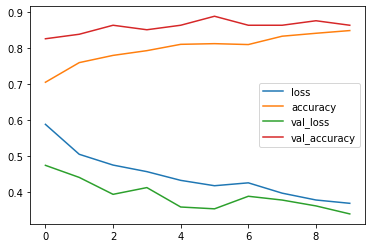

In [49]:
history_df = pd.DataFrame(history.history)
history_df.plot()

**Test the Model**

In [50]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 1s 131ms/step - loss: 0.4585 - accuracy: 0.8088
Test loss: 0.45845314860343933
Test accuracy: 0.8087774515151978


**Load the saved model**

In [51]:
new_model = tf.keras.models.load_model(checkpoint_filepath)
new_model2 = tf.keras.models.load_model(checkpoint_filepath)

In [52]:
scores1 = new_model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])

10/10 [==============================] - 1s 132ms/step - loss: 0.4657 - accuracy: 0.7900
Test loss: 0.46568432450294495
Test accuracy: 0.7899686694145203


In [98]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

**ROC-AUC Score**

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [100]:
y_pred = model.predict(X_test)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, y_pred)))

RF test roc-auc: 0.8424202708606379


**MCC Score**

In [101]:
y_test_1d = []
for item in range(0, len(y_test)):
    if(y_test[item][0]==1):
        y_test_1d.append(0)
    else: 
        y_test_1d.append(1)

In [102]:
y_pred_1d = []
for item in range(0, len(y_pred)):
    if(y_pred[item][0]>0.50):
        y_pred_1d.append(0)
    else: 
        y_pred_1d.append(1)

In [72]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_1d, y_pred_1d)

NameError: name 'y_test_1d' is not defined

**ROC Curve**

In [104]:
y_pred_frac_val = []
for item in range(0, len(y_pred)):
    if(y_pred[item][0]==1):
        y_pred_frac_val.append(y_pred[item][0])
    else: 
        y_pred_frac_val.append(y_pred[item][1])

In [105]:
fpr, tpr, thresholds = roc_curve(y_test_1d, y_pred_frac_val)

In [106]:
def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color= 'orange', label='ROC')
  plt.plot([1,0], [1,0], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics (ROC) Curve')
  plt.legend()
  plt.show()

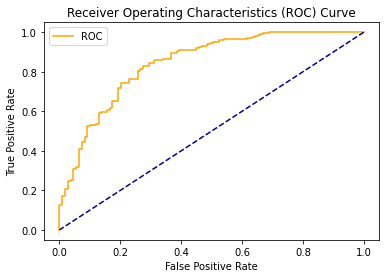

In [107]:
plot_roc_curve(fpr, tpr)

**Getting Best Threshold Value**

In [108]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
  y_pred = np.where(y_pred_frac_val>thres, 1, 0)
  accuracy_ls.append(accuracy_score(y_test_1d, y_pred, normalize = True))
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head(10)

,thresholds,accuracy
59,0.357165,0.805643
60,0.350736,0.802508
58,0.369037,0.802508
57,0.376303,0.802508
56,0.381558,0.802508
52,0.449688,0.799373
71,0.279267,0.796238
53,0.426794,0.796238
51,0.467821,0.793103
63,0.322067,0.793103


**BreakHIS program End**

**Test with colorectal dataset**

**Dataset Load**

In [53]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [54]:
colorec_benign=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/Colorectal Cancer/test/benign')
colorec_malignant=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/Colorectal Cancer/test/malignant')

In [56]:
len(colorec_benign)

5552

In [57]:
data_colorec = pd.DataFrame(index=np.arange(0, len(colorec_benign)+len(colorec_malignant)), columns=["image", "target"])
k=0
for c in [0,1]:
    if c==1:
        for m in range(len(colorec_benign)):
            data_colorec.iloc[k]["image"] = colorec_benign[m]
            data_colorec.iloc[k]["target"] = 0
            k+=1
    else:
        for m in range(len(colorec_malignant)):
            data_colorec.iloc[k]["image"] = colorec_malignant[m]
            data_colorec.iloc[k]["target"] = 1
            k+=1

In [58]:
train_image_colorec=[]
y_colorec=[]

In [59]:
for i in tqdm(range(data_colorec.shape[0])):
    img = image.load_img(data_colorec['image'].iloc[i], target_size=input_shape, grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image_colorec.append(img)

100%|██████████| 7328/7328 [01:25<00:00, 85.81it/s] 


In [60]:
X_colorec = np.array(train_image_colorec)
y_colorec = data_colorec.iloc[:,-1].values

In [61]:
X_train_colorec, X_test_colorec, y_train_colorec, y_test_colorec = train_test_split(X_colorec, y_colorec, random_state=42, test_size=0.99, stratify=y_colorec)
#X_test_colorec, X_val_colorec, y_test_colorec, y_val_colorec = train_test_split(X_test_colorec, y_test_colorec, random_state=42, test_size=0.2, stratify=y_test_colorec, shuffle=True)

In [62]:
X_test_colorec.shape

(7255, 48, 48, 3)

In [63]:
y_test_colorec.shape

(7255,)

In [64]:
y_colorec_ct = keras.utils.np_utils.to_categorical(y_colorec, 2)
y_train_colorec_ct = keras.utils.np_utils.to_categorical(y_train_colorec, 2)
y_test_colorec_ct = keras.utils.np_utils.to_categorical(y_test_colorec, 2)
#y_val_colorec_ct = keras.utils.np_utils.to_categorical(y_val, 2)

In [65]:
y_test_colorec_ct.shape

(7255, 2)

**Test With Full Colorectal Dataset**

In [66]:
#load the model
model_breakhis = tf.keras.models.load_model(checkpoint_filepath)

In [69]:
#getting accuracy using full colorectal dataset
scores1 = model_breakhis.evaluate(X_colorec, y_colorec_ct, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])

229/229 [==============================] - 27s 118ms/step - loss: 1.3706 - accuracy: 0.3678
Test loss: 1.37064528465271
Test accuracy: 0.36776745319366455


In [189]:
epochs = 10
batch_size = 64
history = model_breakhis.fit(X_train_colorec, y_train_colorec_ct,
          batch_size=batch_size,
          callbacks=[model_checkpoint_callback],
          epochs=epochs)

Epoch 1/10
14/14 [==============================] - 9s 639ms/step - loss: 0.5668 - accuracy: 0.7159
Epoch 2/10
14/14 [==============================] - 8s 602ms/step - loss: 0.4805 - accuracy: 0.7371
Epoch 3/10
14/14 [==============================] - 9s 609ms/step - loss: 0.4394 - accuracy: 0.7752
Epoch 4/10
14/14 [==============================] - 9s 620ms/step - loss: 0.4180 - accuracy: 0.8031
Epoch 5/10
14/14 [==============================] - 8s 595ms/step - loss: 0.3863 - accuracy: 0.8177
Epoch 6/10
14/14 [==============================] - 8s 599ms/step - loss: 0.3733 - accuracy: 0.8345
Epoch 7/10
14/14 [==============================] - 8s 597ms/step - loss: 0.3447 - accuracy: 0.8389
Epoch 8/10
14/14 [==============================] - 8s 603ms/step - loss: 0.3311 - accuracy: 0.8501
Epoch 9/10
14/14 [==============================] - 9s 623ms/step - loss: 0.3229 - accuracy: 0.8445
Epoch 10/10
14/14 [==============================] - 8s 598ms/step - loss: 0.3129 - accuracy: 0.8579

In [198]:
#getting accuracy using full colorectal dataset
scores1 = model_breakhis.evaluate(X_test_colorec, y_test_colorec_ct, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])

2767/2767 [==============================] - 875s 315ms/step - loss: 0.4196 - accuracy: 0.7998
Test loss: 0.41960811614990234
Test accuracy: 0.7997515201568604


# AUC Score

In [73]:
y_pred_colorec = model_breakhis.predict(X_colorec)
print('AUC Score: {}'.format(roc_auc_score(y_colorec_ct, y_pred_colorec)))

AUC Score: 0.5130438294697797


# MCC Score

In [78]:
y_test_1d = []
for item in range(0, len(y_colorec)):
    if(y_colorec_ct[item][0]==1):
        y_test_1d.append(0)
    else: 
        y_test_1d.append(1)

In [79]:
y_pred_1d = []
for item in range(0, len(y_pred_colorec)):
    if(y_pred_colorec[item][0]>0.50):
        y_pred_1d.append(0)
    else: 
        y_pred_1d.append(1)

In [80]:
matthews_corrcoef(y_test_1d, y_pred_1d)

0.06722204604172857

# ROC Curve

In [128]:
y_pred_frac_val = []
for item in range(0, len(y_pred_colorec)):
    if(y_pred_colorec[item][0]==1):
        y_pred_frac_val.append(y_pred_colorec[item][0])
    else: 
        y_pred_frac_val.append(y_pred_colorec[item][1])

In [129]:
fpr, tpr, thresholds = roc_curve(y_test_1d, y_pred_frac_val)

In [130]:
def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color= 'orange', label='ROC')
  plt.plot([1,0], [1,0], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics (ROC) Curve')
  plt.legend()
  plt.show()

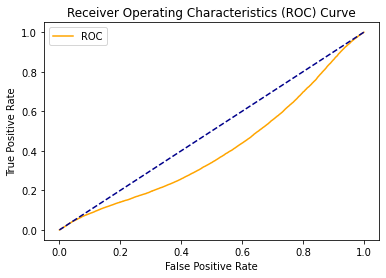

In [131]:
plot_roc_curve(fpr, tpr)

# Getting Best Threshold Value

In [132]:
#accuracy_ls = []
#for thres in thresholds:
#  y_pred = np.where(y_pred_frac_val>thres, 1, 0)
#  accuracy_ls.append(accuracy_score(y_test_1d, y_pred, normalize = True))
#accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis=1)
#accuracy_ls.columns = ['thresholds', 'accuracy']
#accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
#accuracy_ls.head(10)

,thresholds,accuracy
0,2.000000,0.723114
1,1.000000,0.723114
2,1.000000,0.719670
3,1.000000,0.719447
4,1.000000,0.719290
5,1.000000,0.718899
6,1.000000,0.718798
7,1.000000,0.718463
8,1.000000,0.718440
9,0.999999,0.718340
